# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:

# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames


#Ignore warnings:
import warnings
warnings.filterwarnings('ignore')


# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**Hint:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [2]:
#Let us display the unique classes
print "Unique classes in the income variable:" + str(list(np.unique(data["income"])))

# TODO: Total number of records

#I can use either shape or len. I preferred using the len function
#n_records = data.shape[0]

n_records = len(data)

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = len(data[data["income"] == ">50K"])

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = len(data[data["income"] == "<=50K"])

#the following statements ay run faster:
#n_greater_50k = sum(data['income'] == '>50K')
#n_at_most_50k = sum(data['income'] == '<=50K')

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k/(n_greater_50k + float(n_at_most_50k)) * 100

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

#We can use the following code to display the classes counts
#Uncomment the following code
#for col in data.columns:
#    if data[col].dtype == 'O':
#        print col
#        display(data[col].value_counts())

Unique classes in the income variable:['<=50K', '>50K']
Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


Clearly we have imbalance in the target class. So accuracy is not a correct metric to evaluate the algorithms performance. We wil use F-beta scores to evaluate the performance of algorithms. We will use $\beta=0.5$, so that we place more emphasis on the precision than recall. 

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

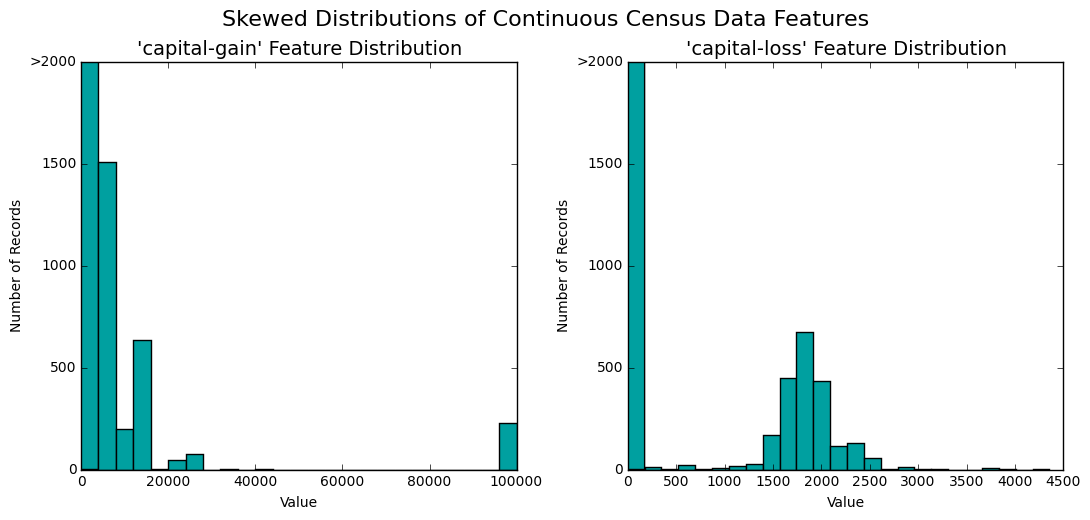

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

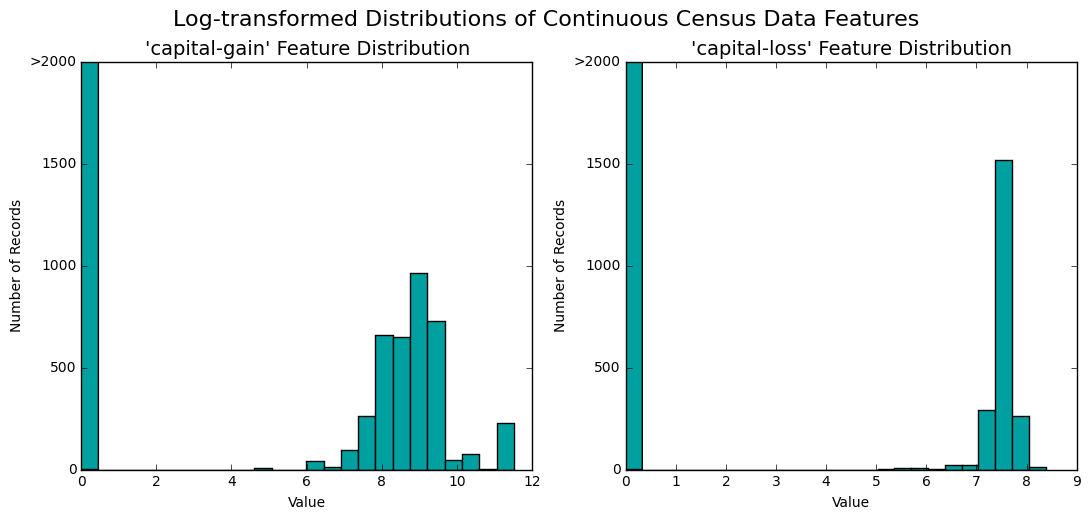

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [6]:
# TODO: One-hot encode the 'features_raw' data using pandas.get_dummies()
categorical = ['workclass','education_level','marital-status','occupation','relationship','race','sex','native-country']


#pd.concat([features_raw,pd.get_dummies(features_raw[categorical], prefix="dummy")], axis=1, join='inner')

features = pd.concat([features_raw[numerical],
                      pd.get_dummies(features_raw[categorical], 
                     prefix="dummy")], 
                     axis=1, join='inner')

# TODO: Encode the 'income_raw' data to numerical values
income = pd.get_dummies(income_raw,drop_first=True)

#display(features.head(n=1))

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
#print encoded

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [7]:
# Import train_test_split
#from sklearn.cross_validation import train_test_split
#Since the cross_validation is deprecated, using model_selection module of sklearn
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

### Question 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  
**Note:** You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

In [8]:
# TODO: Calculate accuracy
accuracy = float(np.mean(income==0))
#precision = TP/(TP+FP)
#recall = TP/(TP+FN)

from sklearn.metrics import recall_score as recall
from sklearn.metrics import precision_score as precision
from sklearn.metrics import fbeta_score
import math

#Since all are predited as negative, TP=0, and FP=0
predicted = np.zeros(len(income))
p = precision(income,predicted)
r = recall(income,predicted)

print "presicion=" + str(p)
print "recall=" + str(r)

# TODO: Calculate F-score using the formula above for beta = 0.5
#fscore will be zero since precision and recall are zeros
#assigning 0 to fscore, since the actual formula of fscore will have a 0/0 (indefinite form),
#since precision and recall are both zeros. But using calculus we can show that 
#as both precision and recall tend to 0, the fscore tends to 0.
fscore = (1 + 0.5**2) * p * r / (0.5**2 * p + r)
if math.isnan(fscore):
    fscore = 0
#fscore = fbeta_score(income, predicted, 0.5, labels=None, pos_label=1, average='binary', sample_weight=None)

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

presicion=0.0
recall=0.0
Naive Predictor: [Accuracy score: 0.7522, F-score: 0.0000]


The $F_{\beta}$ is defined as shown below:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

Since when precision and recall are 0, the $F_{\beta}$ will be evaluated as 0/0, which is indefinite form. But using the following proof, we can conclude that $F_{\beta}$ is 0, when _precision=recall=0_. Based on this proof, in the above code, I evaluated if $F_{\beta}$ is "nan" (indefinite form), and changed the value to 0 (using _math.isnan()_ function)

#### Proof

$$F_{\beta} = \lim_{r, p \rightarrow 0} (1 + \beta^2) \cdot \frac{p \cdot r}{\left( \beta^2 \cdot p \right) + r}$$

where _r = recall_ and _p = precision_.

We will evaluate the above limit in 3 different cases.

_Case-1_

Let us evaluate the limit, by applying $p \rightarrow 0$, followed by applying $r \rightarrow 0$.

$$\lim_{r, p \rightarrow 0} (1 + \beta^2) \cdot \frac{p \cdot r}{\left( \beta^2 \cdot p \right) + r} = \lim_{r \rightarrow 0} \lim_{p \rightarrow 0} (1 + \beta^2) \cdot \frac{p \cdot r}{\left( \beta^2 \cdot p \right) + r} = \lim_{r \rightarrow 0} 0 = 0$$


_Case-2_

Let us evaluate the limit, by applying $r \rightarrow 0$, followed by applying $p \rightarrow 0$.

$$\lim_{r, p \rightarrow 0} (1 + \beta^2) \cdot \frac{p \cdot r}{\left( \beta^2 \cdot p \right) + r} = \lim_{p \rightarrow 0} \lim_{r \rightarrow 0} (1 + \beta^2) \cdot \frac{p \cdot r}{\left( \beta^2 \cdot p \right) + r} = \lim_{p \rightarrow 0} 0 = 0$$

_Case-3_

Let us evaluate the limit, by applying $r \rightarrow 0$ and $p \rightarrow 0$ simultaneously. As $r \rightarrow 0$ and $p \rightarrow 0$ simultaneously, we can assume that $r \rightarrow p \rightarrow 0$. So, let us substitute $r = p$ in the limit and evaluate the limit at $p \rightarrow 0$.

$$\lim_{r, p \rightarrow 0} (1 + \beta^2) \cdot \frac{p \cdot r}{\left( \beta^2 \cdot p \right) + r} = \lim_{p \rightarrow 0} (1 + \beta^2) \cdot \frac{p \cdot p}{\left( \beta^2 \cdot p \right) + p} = \lim_{p \rightarrow 0} (1 + \beta^2) \cdot \frac{p}{\beta^2 + 1} = 0$$

In all the three cases the limit evaluates to 0. Hence we can conclude that the $F_{\beta}$ function exists when both recall and precision assume 0, and the $F_{\beta}$ value will be 0, in such scenario. 



###  Supervised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*

**Answer: **

We will be using the following 3 machine learning algorithms to build a model that accurately predicts if a person's salary is greater than \$50K:

* Logistic Regression
* Random Forests
* Gradient Tree Boosting

### Logistic regression

**_Advantags of logistic regression_** The logistic regression is a popular method for a binary classification problems. Logistic regression is computationally easy to implement, and the variables can be transformed to higher degrees to fit non-linear functions. The logistic regression model is highly interpretable. Logistic regression is used in various fields, including machine learning, most medical fields, and social sciences (https://en.wikipedia.org/wiki/Logistic_regression). When the class boundaries are not well separated, logistic regression has an advantage over other methods such as linear discriminant analysis. Logistic regression can output the probabilities of the event, and this helps us to choose the optimal cutoff to handle imbalanced classes in the target variable.

**_Disadvantags of logistic regression_**
Logistic regression is a parametric method, in which we have to determine which variables should be used to build the model, along with an assumption about the functional form of the model. If we assume a simple functional form, then the bias of the model may increase. We can increase the complexity of the model, by transforming the variables to higher powers or introducing interactions between the variables. For instance to test the interaction effects we have to test many combinations of the variables to check if any combination improves the model's performance. Logistic regression can overfit the data, if we include more number of variables. Logistic regression under performs when the classes in the target variable are well separated. Also if the available data is small, and the variables have approximately normal distribution in each of the target classes, the logistic regression does not perform well (_Gareth James, Daniela Witten, Trevor Hastie, Robert Tibshirani - An Introduction to Statistical Learning with Applications in R, Sprienger 2013_). We can determine the important variables in the dataset using forward/backward/mixed selection methods, although the logistic regression does not provide any information about the potential interaction between variables. 

I chose logistic regression as a potential model for this data set, since we are dealing with a binary classification problem. Also logistic regression model can be intrepreted easily, and if we get the same or better model performance for logistic regression than the other 2 methods (Random Forests and Gradient Boosting), then we will prefer logistic regression method, since it is a simple model.

### Random Forests

Random forests is an ensemble learning algorithm that is based on building many decision trees (weak learners) and combining the trees outputs to make a final prediction. Random forests are used to solve classification, regression problems (supervised learning) and also in clustering (unsupervised learning). As per https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm, Random forests have the following advantages:

**_Advantages of Random Forests_**

* It is unexcelled in accuracy among current algorithms.
* It runs efficiently on large data bases.
* It can handle thousands of input variables without variable deletion.
* It gives estimates of what variables are important in the classification.
* It generates an internal unbiased estimate of the generalization error as the forest building progresses.
* It has an effective method for estimating missing data and maintains accuracy when a large proportion of the data are missing.
* It has methods for balancing error in class population unbalanced data sets.
* Generated forests can be saved for future use on other data.
* Prototypes are computed that give information about the relation between the variables and the classification.
* It computes proximities between pairs of cases that can be used in clustering, locating outliers, or (by scaling) give interesting views of the data.
* The capabilities of the above can be extended to unlabeled data, leading to unsupervised clustering, data views and outlier detection.
* It offers an experimental method for detecting variable interactions.

**_Disadvantages of Random Forests_**

Random forests are not interpretable. Although the documentation (https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm) on random forests claim that building random forests is fast, as per my personal experience, I was not able to fit a random forest model successfully on a Kaggle data set (Allstate recruitment challange), on a machine with 6GB RAM. The data has around 180K records (200MB size), and 150 variables. The software implementation of Random forests in R, cannot accept categorical variables with more than 51 levels. Gradient boosting has performed very well for the Kaggle data set.

I chose random forest as a potential algorithm to build the predictive model for the given data set, since I can compare the Random forest performance with Gradient boosting method. I also would like to evaluate, if the sample size (while building the decision trees in the Random forests) has any effect on the performance (the documentation https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm claims that the sample size has no effect, but in the reference (Sebastian Raschaka - Python Machine Learning, PACKT Publishing 2015, PP 90), it is mentioned that the a bigger sample size can result in overfitting (As per the book,  greater the sample size greater the chance of overfit). The author of Random Forests (https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm) claims that the Random forests will never overfit. So I would like to test if Random forests overfit the data based on the sample size and/or the number of variables selected while building each node of the decision tree in the forest.

### Gradient Tree Boosting

Gradient boosting is an ensemble method, which is based on building many decision trees. But unlike random forests, each tree is sequentially built by fitting the tree using the residual of the previous trees (which are linearly combined). This learning algorithm can be applied to both regression and classification problems. 
As per http://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting, Gradient Tree Boosting models are used in a variety of areas including Web search ranking and ecology.

**_Advantages of Gradient Tree Boosting_**
* Natural handling of data of mixed type (= heterogeneous features)
* Predictive power
* Robustness to outliers in output space (via robust loss functions)

**_Disadvantages of Gradient Tree Boosting_**
* Scalability, due to the sequential nature of boosting it can hardly be parallelized.

I chose gradient boosting, since this method can be successfully applied to classification problems (although it is preferred to use Random forests, if we have more than 2 classes - see http://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting). Since we have binary classification problem, we can use gradient boosting method. Also, since we are using Random forests as a potential model, we can compare gradient boosting performance with random forests.

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [9]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score

#from datetime import datetime
from time import time
from sklearn.metrics import accuracy_score 
from sklearn.metrics import fbeta_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    beta = 0.5
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    
    if sample_size < len(X_train):
              X_discard, X_train_sample, y_discard, y_train_sample = \
                     train_test_split(X_train, y_train, test_size = sample_size, random_state = 0)
    else:
        X_train_sample = X_train
        y_train_sample = y_train
    
    
    start = time() # Get start time
    #learner = None
    learner.fit(X_train_sample,y_train_sample)
    #end = datetime.now() # Get end time
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    #start = datetime.now() # Get start time
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[0:300])
    #end = datetime.now() # Get end time
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end-start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[0:300], predictions_train, normalize=True) 
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test, normalize=True)
    
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[0:300], predictions_train, beta)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

LogisticRegression trained on 362 samples.
LogisticRegression trained on 3618 samples.
LogisticRegression trained on 36177 samples.
RandomForestClassifier trained on 362 samples.
RandomForestClassifier trained on 3618 samples.
RandomForestClassifier trained on 36177 samples.
GradientBoostingClassifier trained on 362 samples.
GradientBoostingClassifier trained on 3618 samples.
GradientBoostingClassifier trained on 36177 samples.


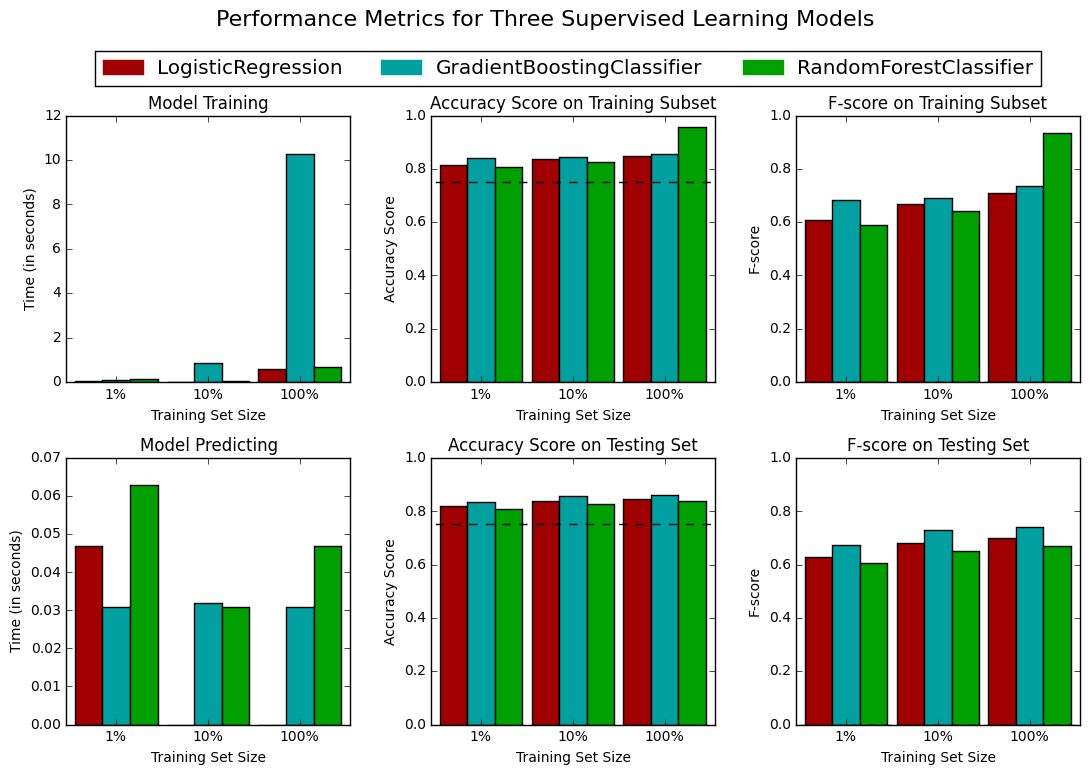

In [10]:
# TODO: Import the three supervised learning models from sklearn

from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# TODO: Initialize the three models
clf_A =  linear_model.LogisticRegression(random_state=0)
clf_B = RandomForestClassifier(random_state=0)
clf_C = GradientBoostingClassifier(random_state=0)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
n_rows = len(X_train)

#Must be an integer, else will get an error
samples_1 = int(round(0.01*n_rows))
samples_10 = int(round(0.1*n_rows))
samples_100 = n_rows

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

### Default parameters effect
We trained the three models with the default parameters. Some of these default parameters will effect the training time and also the prediction time, and it is worth discussing these parameters, before we interpret the above plots. The sklearn package will use the following default parameters for the three training algorithms considered:

_1. Logistic regression_: 

   * C=1, Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization. With C as 1, no regularization is performed by default.

_2. Random Forests:_

   * n_estimators = 10. Number of trees in the forests
   
   * max_features = auto. The number of features to consider when looking for the best split. If “auto”, then max_features=sqrt(n_features)
   
   * max_depth = None. The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples 
               
   * min_samples_leaf = 1. The minimum number of samples required to be at a leaf node
   
   * n_jobs = 1. Controls how many trees can be built parallely (depends on the number of processors).
   
Note: 
1. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default)
2. The max_depth value change with the size of the training data, and hence the training time, and also the prediction time vary with this parameter


_3. Gradient Boosting Trees:_

   * subsample=1. The fraction of samples to be used for fitting the individual base learners. If 1, the complete training data is used as sample data. This parameter controls the amount of training data available to build the individual tree, and hence the training time varies based on this parameter, since the training data volume changes with this parameter. This parameter should not have any effect on the prediction time.
   
   * max_features=None. The number of features to consider when looking for the best split. If None, then max_features=n_features. The training time varies with this parameter, but the prediction time should not depend on this parameter.     
   
   * max_depth = 3. The Maximum depth of the individual regression estimators. Will effect the training time, and also the prediction time. Greater the depth of the trees, greater the time needed to reach the leaf node, and hence greater the time to make prediction. Similarly greater the tree depth, greater the time needed to build the tree. 
   
   * n_estimators = 100. The number of boosting stages to perform. 

If you observe, Random forests and Gradient Boosted Trees have n_estimators parameter as 10 and 100 respectively. This means Random forests build 10 trees, while Gradient Boosting algorith will build 100 trees by default. This effects the training time and also the prediction times of both the algorithms (training time is different since different number of trees need to be built, and prediction time is different, since an an unseen observation need to be evaluated by different number of trees to make final prediction). The number of features considered for random forests (at each node in a tree) is less than the number of features considered (at each node in a tree) for gradient boosted trees. Hence the training time may vary based on this parameter. The max_depth of random forests is None by default, and this results in expanding the trees to a maximum depth possible or till the min_samples_split is reached (which is 2 by default). For Gradient boosted trees, the max_depth is 3 by default. Hence the training time and prediction time will be different between Random forests and Gradient boosted trees, based on the max_depth parameter.

### Inference
From the bar plots, we can infer the following:

* Training time of Gradient Boosting Classifer is almost 10 times more than the Random forests and Logistic regression algorithms (see the first plot "Model Training" for training size of 100%).
* From the second plot ("Accuracy score on training subset"), the accuracy score on the training data is slightly more for Gradient boosting method (see training sizes of 1% and 10% in the plot), while the accuracy of Random forests method has increased drastically to more than 95%, when trained on the complete training data, and when evaluated on the training data. This suggests that an overfitting may be occurring in case of Random Forests, when we used the complete training data to train the random forest model.
* From the third plot ("F Score on training subset) the F-Score (with beta=0.5) on the training data is the largest for Random forests, when trained on the complete training data, and when evaluated on the complete training data. This trend also suggests that overfitting is happening in Random forests, when trained on the complete training data. For training data sizes of 1% or 10%, the F-Score of Gradient Boosting is more than the Logistic Regression and Random forests. For these sample sizes (1% and 10%) the F-Score of Logistic regression is better than the Random forests.

* The fourth plot ("Model predicting"), shows that the Logistic regression's prediction time is almost constant for different training data sizes. But the prediction times of Random forest vary, based on the training data size. The gradient boosted tree's prediction time also varies with the training data size, although not as significant as the Random forests. This could be due to the depth of the tree that needs to be built for Random forests will change with the training data. 

* The fifth plot ("Accuracy score on testing set"), shows that the accuracy of the Gradient bossted method is always better than the Logistic regression and Random forests. Surprisingly, the logistic regression model (which is regarded as a simple model, when compared to the Random forests), has superior accuracy than the Random forests. This plot confirms that Random forests have overfit the training data (since random forests have performed extremely well on the training data, but underperformed on the test data). The same reasoning can be applied to the sixth plot (F-Score on testing set"), but with one difference - The F-Score on the test data has increased for the three models, with the training data size, while the accuracy has remained almost constant (with the training data size).

* Since the Random forests are showing an overfit behavior with the sample size increase, we can confirm that sample size can be tweaked to improve the performance of the random forests. Also we are choosing one variable from $\sqrt{\mbox{No. of features}}$ to build a node at each tree. This parameter can also be tweaked to improve the random forests performance.

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000.*  
**Hint:** Your answer should include discussion of the metrics, prediction/training time, and the algorithm's suitability for the data.

**Answer: **
From the previous section "Default parameters effect" and "Inference", we found that the Gradient boosting algorithm has obtained the best test score. But the training time of this algorithm is more, when compared to the other two algorithms. This could be due to the default number of trees to be built in Random forests is far less than the default number of trees to be built for Gradient boosted trees. But given the fact that Random forests are over fitting the data, we will consider Boosted regression trees for this data set. We will also discard logistic regression from further consideration, since we are not interested in model interpretability, and we are interested to accurately predict the outcome. However, as a part of future work, I would like to perform the following:
1. Tune Random forests parameters (sample size and number of features used at each node in the tree) and compare the model performance with the fully tuned gradient boosted trees
2. Compare if Gradient boosted trees and Random forests have output the same/different variables as significant variables, and if the output the same/different interactions between the variables.

### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: ** 

1. Gradient boosting combines several simple prediction models to create an "ensemble" of models that can make more accurate predictions. 
2. In our case, the model is trained with existing census data (e.g., age, gender, etc), and uses that data to find rules that separate those with income above or below 50K.
3. During successive rounds of training, new rules (i.e., decision trees) are learned that essentially create a flowchart of yes/no questions that can be used to determine the class of unseen data.
4. With each round, the model looks at where a learned tree predicted poorly and tries to build the next tree using the prediction errors made by the previous trees. 
5. The trees are then combined to create the final model, where the trees that do a better job of classifying are given more _importance_ or _weightage_ than the trees that perform poorly
6. Using this model trained with data of known individuals, the model can look at new unknown individuals and predict whether an unknown individual's income is >50K or not.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

### Gradient boosted classifier parameters
As per _J. Elith, J. R. Leathwick, and T. Hastie (2008), A working guide to boosted regression trees, Journal of
Animal Ecology_, we have the following parameters that can be tuned to improve the performance of gradient boosted trees:

* Sample size: What fraction of data needs to be randomly sampled from the training data set while building the trees. "subsample" parameter of sklearn.ensemble.GradientBoostingClassifier() can be used to control this parameter. Elith et al, suggested to use a value between 0.5 and 0.75 as the sample size. Introducing some randomness into a boosted model usually improves accuracy and speed and reduces over-fitting (Friedman 2002), but it does introduce variance in fitted values and predictions between runs 

* Learning rate: As the learning rate increases the number of trees needed to obtain the minimal CV (Cross Validation) error decreases. But the obtained CV error can be further reduced, if we build more trees with slow learning rate. We will use a learning rate of 0.1, 0.01, and 0.05 to evaluate the models performance. This is controlled by learning_rate parameter of sklearn.ensemble.GradientBoostingClassifier()

* Number of trees: If we have more trees in the model, the model can overfit the data. But in general the model's performance improves as more trees are built with a slow learning rate. If the learning rate is high, then less number of trees are needed to obtain the least CV error (although not optimal CV error). If the learning rate is low, then more trees are needed to obtain a lower CV error, and in general this CV error is lesser than the least possible CV error obtained using high learning rate. The n_estimators variable of sklearn.ensemble.GradientBoostingClassifier() will control this hyper parameter.

* Maximum tree depth: This parameter controls the interactions between the variables. Greater the interactions used, sooner we reach the optimal number of trees needed to achieve least possible CV error (although not optimal). 

So we will use the following combinations of values for these parameters, using grid search, to identify the optimal parameter combination:

|Learning rate   | Sample size         | Maximum num. of trees | Interactions  | 
| :------------: | :-----------------: | :-------------------: | :-----------: | 
| 0.1            | 0.5         |  100                  |  2            | 
| 0.05           | 0.5         |  500                  |  3            |
| 0.01           | 0.5         |  1000                 |  4        |

Once the optimal parameters are determined, we can use "oob\_improvement\_" of gradient boosted model to identify the optimal number of trees needed for the final model. 

In [11]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
y_train_temp = y_train
y_train = np.array(y_train)
# TODO: Initialize the classifier
clf = GradientBoostingClassifier(random_state=0)


# TODO: Create the parameters list you wish to tune

parameters = [{'learning_rate':[0.1],
              'n_estimators':[100],
              'max_depth':[2],
              'subsample':[0.5]},
             {'learning_rate':[0.05],
              'n_estimators':[500],
              'max_depth':[3],
              'subsample':[0.5]},
             {'learning_rate':[0.01],
              'n_estimators':[1000],
              'max_depth':[4],
              'subsample':[0.5]}]


# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5,greater_is_better=True)


# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(estimator=clf, param_grid=parameters,  scoring=scorer,  cv=5,  n_jobs=-1)
#grid_obj = GridSearchCV(clf, parameters,  scoring=scorer,  cv=5)


# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train.ravel())

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)
y_train=y_train_temp
# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

print "Best Model parameters\n------"
print best_clf


c:\users\sekhar\anaconda\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
c:\users\sekhar\anaconda\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Unoptimized model
------
Accuracy score on testing data: 0.8630
F-score on testing data: 0.7395

Optimized Model
------
Final accuracy score on the testing data: 0.8650
Final F-score on the testing data: 0.7402
Best Model parameters
------
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=1000, presort='auto', random_state=0,
              subsample=0.5, verbose=0, warm_start=False)


### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |       0.7522              |   0.863                | 0.865                |
| F-score        |    0                 |   0.7395                |   0.7402       |


**Answer: **
The accuracy and F-Score of the Unoptimized and optimized models are significantly higher than the Benchmark predictor. This shows that our model is performing well when compared to the naive predictor. But there is no significant improvement between the scores of Unoptimized and Optimized models. Both the unoptimized and optimized models were built using Gradient boosted trees algorithm. The unoptimized model was built using the default parameters, while the optimized model has been built with customized parameters. The parameters difference is shown below:

|Parameter| Unoptimized model | optimized model |
| :------: | :---------------: | :-------------: |
| Learning rate | 0.1 | 0.01 |
| Sample size | 100% | 50% |
| Max. trees | 100 | 1000 |
| Interactions | 3 | 4 |

The time to build optimized model is significantly greater than the unoptimized model. Hence we prefer using the unoptimized model, since there is NO significant difference between the F-Scores and Accuracy scores. To re-confirm if our decision is correct, let us plot the ROC curves for the "Unoptimized model" and the "Optimized model". If the area under the curves is approximately same, then we will reassure that our decision to consider the unoptimized model is correct.

Area under the cure is for unoptimized classifier:0.920760035008
Area under the cure is for best clf:0.923778792219


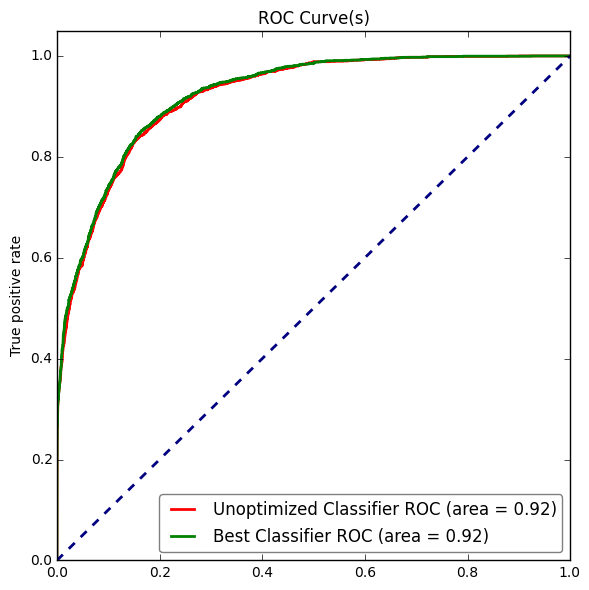

In [20]:

#Let us create a function to plot the ROC curves
def plot_roc_curves(fpr,tpr,ax,models,colors=["red","green","darkorange","green","black","magenta","cyan"]):
    import matplotlib.pyplot as plt
    from sklearn.metrics import auc
    lw=2 #Line weight
    for key in range(len(fpr)):
        line1, = ax.plot(fpr[key], tpr[key], linewidth=2,color=colors[key],
                 label=models[key]+' ROC (area = %0.2f)' % auc(fpr[key],tpr[key]))
    line2,=ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.legend(loc='lower right',fancybox=True, framealpha=0.5)
    
    ax.set_ylabel('True positive rate')
    ax.set_title('ROC Curve(s)')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    return ax
    

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#Dictionary to collect the False Positive Rates at various probabilities thresholds
fpr = dict()

#Dictionary to collect the True Positive Rates at various probabilities thresholds
tpr = dict()

#Dictionary to collect the probability thresholds used to compute the TPR and FPR
thresholds=dict()

#Get the probabilities that the target class=1 (income > 50K) using unoptimized classifier
clf_test_scores=np.array(pd.DataFrame(clf.predict_proba(X_test))[1])

#Get the FPR, TPR, thresholds used for unoptimized classifier
fpr[0], tpr[0], thresholds[0] = roc_curve(y_test, y_score=clf_test_scores, pos_label=1)

#Get the probabilities that the target class=1 (income > 50K) using optimized classifier
best_clf_test_scores=np.array(pd.DataFrame(best_clf.predict_proba(X_test))[1])

#Get the FPR, TPR, thresholds used for optimized classifier
fpr[1], tpr[1], thresholds[1] = roc_curve(y_test, y_score=best_clf_test_scores, pos_label=1)


print "Area under the cure is for unoptimized classifier:" + str(auc(fpr[0],tpr[0]))
print "Area under the cure is for best clf:" + str(auc(fpr[1],tpr[1]))


    
    
fig, ax = plt.subplots(figsize=(6,6))
#fig.suptitle('Categorical variables bar plots')
models=["Unoptimized Classifier", "Best Classifier"]
plot_roc_curves(fpr,tpr,ax,models)
plt.tight_layout()


From the above ROC curves plot we can infer that Unoptimized model and Best model have the same AUC (Area Under the Curve), so we can use unoptmized mode.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?_

**Answer:**

Let us draw bar charts to determine if any of the categorical variables help us to determine if a person can be a potential donor.


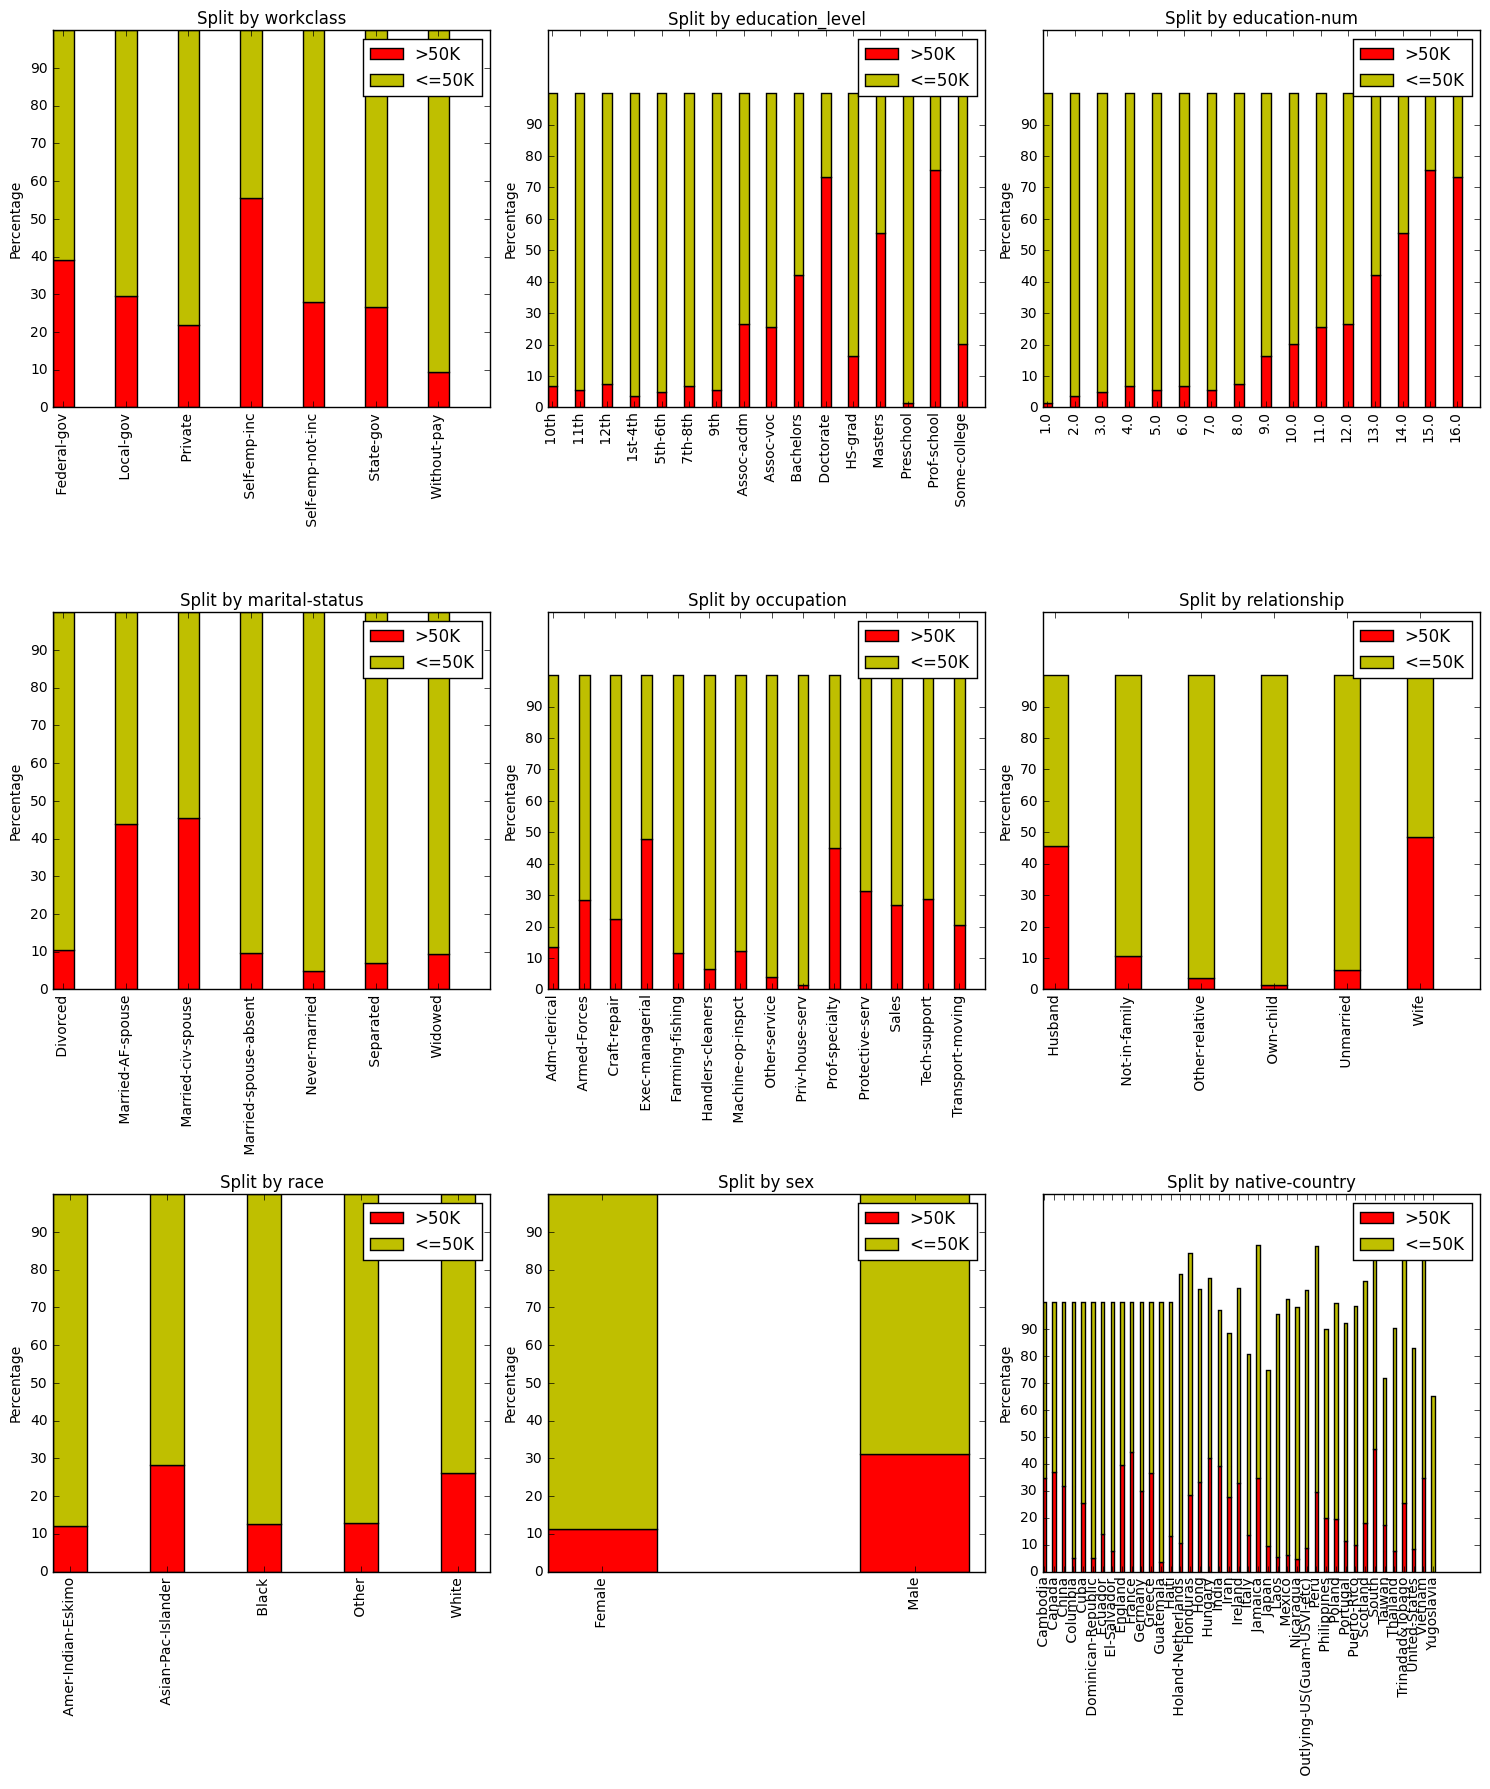

In [21]:
#Function to plot bar charts
import matplotlib.pyplot as plt

def plot_bar_chart(df,x,y,ax,display_legend=1):
            N = len(data[x].unique())
            xtick = tuple(data[x].unique())

            ind = np.arange(N)    # the x locations for the groups
            width = 0.35       # the width of the bars: can also be len(x) sequence
            #width = 0.1       # the width of the bars: can also be len(x) sequence

            plot_df = data[[x,y]]
            plot_df_1 = plot_df.groupby([x,y]).size().reset_index()
            plot_df_2  = plot_df.groupby([x]).size().reset_index()
            plot_df_1.columns = ["x", "y", "count"]
            plot_df_2.columns = ["x","total_count"]
            plot_df = pd.merge(plot_df_1, plot_df_2, how='inner', on=['x'])
            plot_df["percentage"] = plot_df["count"]/plot_df["total_count"]*100
            temp_df = plot_df[plot_df["percentage"] == 100]
            
            #Taking care of observations which are missing (padding with 0%)
            if len(temp_df) > 0:
                temp_df_1 = temp_df[temp_df["y"] == "<=50K"]
                temp_df_2 = temp_df[temp_df["y"] == ">50K"]
                temp_df_1["y"] = ">50K"
                temp_df_1["percentage"] = 0
                temp_df_2["y"] = "<=50K"
                temp_df_2["percentage"] = 0

                temp_df = pd.concat([temp_df_1,temp_df_2])
                plot_df = pd.concat([plot_df,temp_df])
                        
            top_data = plot_df[plot_df["y"] == ">50K"]
            bottom_data = plot_df[plot_df["y"] == "<=50K"]
            p1 = ax.bar(ind, top_data["percentage"], width, color='r')
            p2 = ax.bar(ind, bottom_data["percentage"], width, color='y',
                         bottom=top_data["percentage"])

            
            ax.set_ylabel('Percentage')
            ax.set_title('Split by ' + x)
            #ax.set_xticks(ind + width/2., tuple(plot_df_2["x"]),rotation='vertical')
            ax.set_xticks(ind + width/2.0) 
            ax.set_xticklabels(tuple(plot_df_2["x"]),rotation='vertical')
            
            ax.set_yticks(np.arange(0, 100, 10))
            if display_legend == 1:
                ax.legend((p1[0], p2[0]), ('>50K', '<=50K'))
#            return ax

fig, ax = plt.subplots(nrows=3, ncols = 3, figsize=(15,18))
#fig.suptitle('Categorical variables bar plots')

plot_bar_chart(data,"workclass","income",ax[0,0],1)
plot_bar_chart(data,"education_level","income",ax[0,1],1)
plot_bar_chart(data,"education-num","income",ax[0,2],1)
plot_bar_chart(data,"marital-status","income",ax[1,0],1)
plot_bar_chart(data,"occupation","income",ax[1,1],1)
plot_bar_chart(data,"relationship","income",ax[1,2],1)
plot_bar_chart(data,"race","income",ax[2,0],1)
plot_bar_chart(data,"sex","income",ax[2,1],1)
plot_bar_chart(data,"native-country","income",ax[2,2],1)
plt.subplots_adjust(top=0.85)
plt.tight_layout()

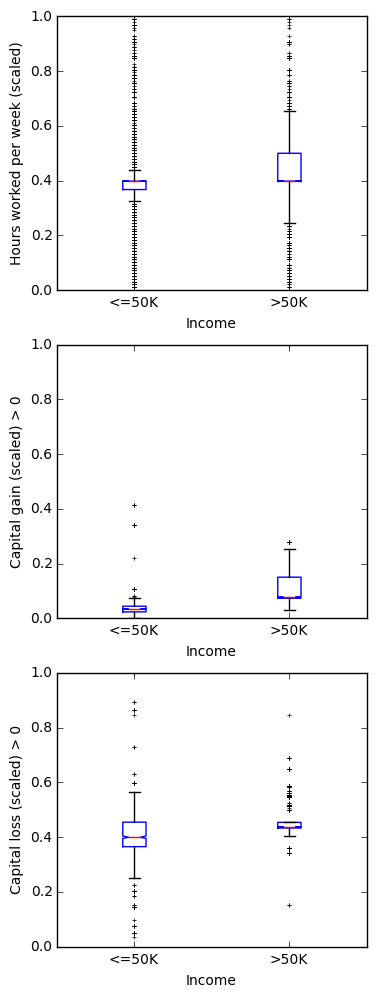

In [27]:
low_pay = features[data["income"] == "<=50K"]
hi_pay = features[data["income"] == ">50K"]

cap_gain_low = low_pay[low_pay["capital-gain"]>0]
cap_gain_hi = hi_pay[hi_pay["capital-gain"]>0]

cap_loss_low = low_pay[low_pay["capital-loss"]>0]
cap_loss_hi = hi_pay[hi_pay["capital-loss"]>0]

bpdata_1 = [[low_pay["hours-per-week"]],hi_pay["hours-per-week"]]
bpdata_2 = [[cap_gain_low["capital-gain"]],cap_gain_hi["capital-gain"]]
bpdata_3 = [[cap_loss_low["capital-loss"]],cap_loss_hi["capital-loss"]]
#print bpdata_2
fig, ax = plt.subplots(nrows=3, ncols = 1, figsize=(4,12))
pos = np.array(range(2)) + 1
bp1 = ax[0].boxplot(bpdata_1, sym='k+', positions=pos,
                notch=1)
                #,bootstrap=5000,
                #usermedians=medians,
                #conf_intervals=conf_intervals)
bp2 = ax[1].boxplot(bpdata_2, sym='k+', positions=pos,
                notch=1)

bp3 = ax[2].boxplot(bpdata_3, sym='k+', positions=pos,
                notch=1)

ax[0].set_xlabel('Income')
ax[0].set_ylabel('Hours worked per week (scaled)')
ax[0].set_xticklabels(["<=50K",">50K"])

ax[1].set_xlabel('Income')
ax[1].set_ylabel('Capital gain (scaled) > 0')
ax[1].set_xticklabels(["<=50K",">50K"])

ax[2].set_xlabel('Income')
ax[2].set_ylabel('Capital loss (scaled) > 0')
ax[2].set_xticklabels(["<=50K",">50K"])


plt.setp(bp1['whiskers'], color='k', linestyle='-')
plt.setp(bp1['fliers'], markersize=3.0)

plt.setp(bp2['whiskers'], color='k', linestyle='-')
plt.setp(bp2['fliers'], markersize=3.0)

plt.setp(bp3['whiskers'], color='k', linestyle='-')
plt.setp(bp3['fliers'], markersize=3.0)

plt.show()

Based on the above plots, I would choose the following 5 variables as the important variables:
1. capital-gain 
2. capital-loss and 
3. hours-per-week
4. education-level (If a person's education level is a doctorate or proff-school, then there is 70% chance that he will have >50K income. Even a Master's degree holder has a 0.5 probability that he has more than 50K income) 
(or)
education-num - If the number of years of education is more than 14 years, then there is 70% chance that the person's income will be more than 50K 
5. relationship - If the relationship is wife or husband, then there is more than 40% chance that the person has more than 50K income
(or)
marital-status - If the person is Married-AF-spouse and Married-civ-spouse, then there is approximately 45% chance that they have more than 50K income.

The quantative variables (capital-gain, capital-loss, hours-per-week) have different IQR (Inter-Quartile ranges), which are different for two classes (>50K and <=50K). Hence these 3 variables should be important variables.

The education-level and education-num should be correlated with each other. Similarly the relationship and marital-status should also be correlated with each other. Hence we will pick only one of these from each group.

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

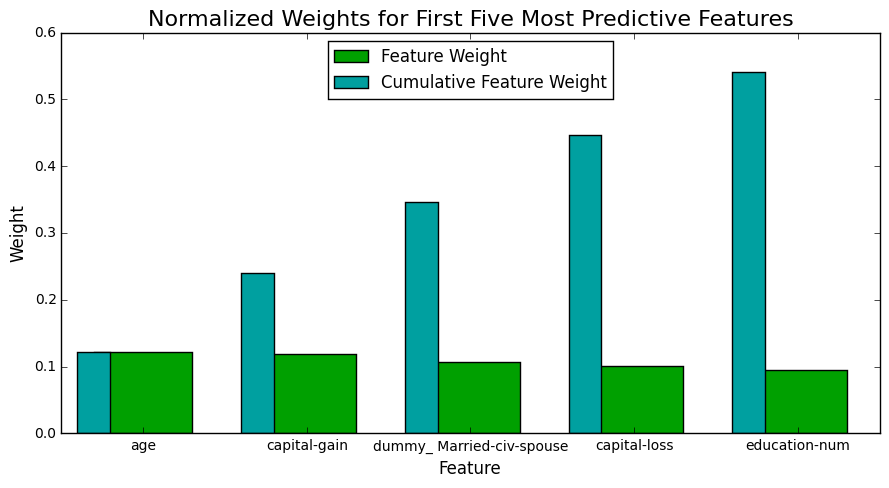

In [22]:
# TODO: Import a supervised learning model that has 'feature_importances_'

# TODO: Train the supervised model on the training set 
model = best_clf

# TODO: Extract the feature importances
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_

**Answer:**

I was close to the answer, since the gradient boosted trees model also picked almost the same variables. I chose relationship as one of the important variables, and the algorithm has choosen the dummy variables associated with Married-civ-spouse class from relationship variable. 

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [23]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]
#save the default parms classfier (unoptimized)
clf1=clf
# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8650
F-score on testing data: 0.7402

Final Model trained on reduced data
------
Accuracy on testing data: 0.8585
F-score on testing data: 0.7243


In [27]:
print "Unoptimized model"
print clf1
clf1 = (clone(clf1)).fit(X_train_reduced, y_train)
print "Optimized model"
print clf

optimized_reduced_predictions = clf.predict(X_test_reduced)
unoptimized_reduced_predictions = clf1.predict(X_test_reduced)


Unoptimized model
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=0,
              subsample=1.0, verbose=0, warm_start=False)
Optimized model
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=1000, presort='auto', random_state=0,
              subsample=0.5, verbose=0, warm_start=False)


### Best model selection using the reduced data set
We will use the ROC curves to select the best model from optimized gradient boosted model, and unoptimized gradient boosted model (built with default parameters).

### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

Area under the cure is for unoptimized classifier:0.90987594648
Area under the cure is for best clf:0.912099992044


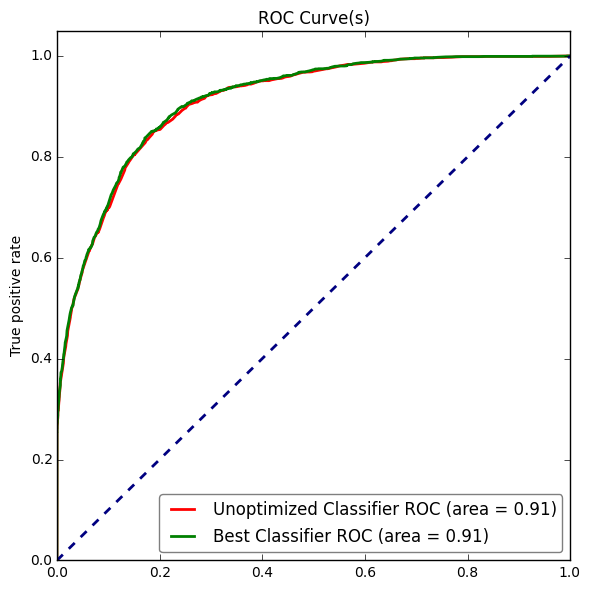

In [28]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#Dictionary to collect the False Positive Rates at various probabilities thresholds
fpr = dict()

#Dictionary to collect the True Positive Rates at various probabilities thresholds
tpr = dict()

#Dictionary to collect the probability thresholds used to compute the TPR and FPR
thresholds=dict()

#Get the probabilities that the target class=1 (income > 50K) using reduced classifier
clf_test_scores=np.array(pd.DataFrame(clf1.predict_proba(X_test_reduced))[1])

#Get the FPR, TPR, thresholds used for unoptimized classifier
fpr[0], tpr[0], thresholds[0] = roc_curve(y_test, y_score=clf_test_scores, pos_label=1)

#Get the probabilities that the target class=1 (income > 50K) using optimized classifier
best_clf_test_scores=np.array(pd.DataFrame(clf.predict_proba(X_test_reduced))[1])

#Get the FPR, TPR, thresholds used for optimized classifier
fpr[1], tpr[1], thresholds[1] = roc_curve(y_test, y_score=best_clf_test_scores, pos_label=1)


print "Area under the cure is for unoptimized classifier:" + str(auc(fpr[0],tpr[0]))
print "Area under the cure is for best clf:" + str(auc(fpr[1],tpr[1]))


    
    
fig, ax = plt.subplots(figsize=(6,6))
#fig.suptitle('Categorical variables bar plots')
models=["Unoptimized Classifier", "Best Classifier"]
plot_roc_curves(fpr,tpr,ax,models)
plt.tight_layout()


**Answer:**
I would consider the reduced data as the training set, since the accuracy difference between the best predictor and the reduced data predictor is less than 1%, and the F-Score difference is approximately 1.6%. These differences are not significant, hence it is preferred to consider a reduced data set, which has just 5 features, when compared to the 103 features (after hot encoding). 

Between the optimized and unoptimized models (trained on the reduced training set, and tested on the reduced test data set), ROC curves are similar, and their AUC are also approximately same. Hence we will prefer the unoptimized model as the final model built using the reduced training data set.

### Confusion matrix with probability threshold of 0.5

0.858927584301


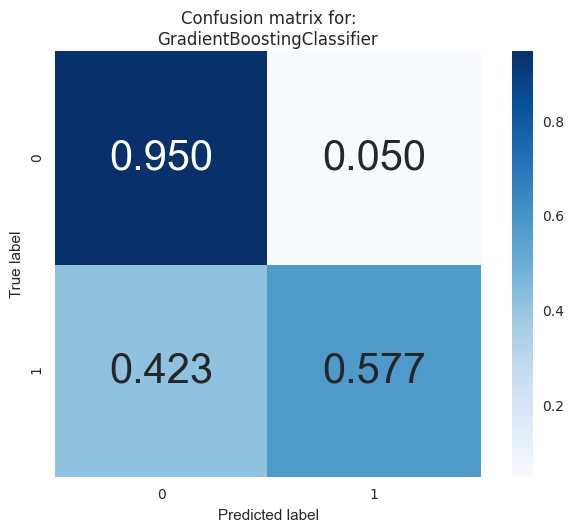

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

unoptimized_reduced_predictions = clf1.predict(X_test_reduced)
cm = confusion_matrix(y_test, unoptimized_reduced_predictions)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


# view with a heatmap
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for:\n{}'.format(clf1.__class__.__name__));

print np.mean(y_test[">50K"] == unoptimized_reduced_predictions)

### Finding the optimal threshold value
The positive vs negative cases are divided in the ratio of 24:76 approximately. Our perdiction algorithm's performance boosts, if we tune the threshold value (or cut off probability value). By default the algorithm uses 0.5 as the probability threshold to predict if income is >50K. But given the class imbalance (24:76), we can tune this threshold. We CANNOT use test data set to find this threshold, since this would result in overfit. So we will use a cross validation technique to find this optimal value (see http://appliedpredictivemodeling.com/blog/2014/2/1/lw6har9oewknvus176q4o41alqw2ow). At different values of thresholds we will plot the sensitivity and specificity, and the distance between the (sensitivity, specificity) and the point (0,1) in the ROC curve. The algorithm performs best when this distance is minimum. We randomly choose 80% of the data for training and remaining data for testing. This is repeated for 6 times (with different random seed values). The following code will fit the gradient boosted trees (with default parameters), on the reduced training data set with just 5 features, for 6 times (on randomly sampled training data from the training data set). 

In [60]:
#Dictionary to collect the False Positive Rates at various probabilities thresholds
fpr = dict()

#Dictionary to collect the True Positive Rates at various probabilities thresholds
tpr = dict()

#Dictionary to collect the probability thresholds used to compute the TPR and FPR
thresholds=dict()


for i in range(6):
        X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(
                  X_train_reduced, y_train, test_size=0.2, random_state=i+10)

       
        clf1 = (clone(clf1)).fit(X_train_temp,y_train_temp)
        clf_test_scores=np.array(pd.DataFrame(clf1.predict_proba(X_test_temp))[1])
        
        fpr[i], tpr[i], thresholds[i] = roc_curve(y_test_temp, y_score=clf_test_scores, pos_label=1)



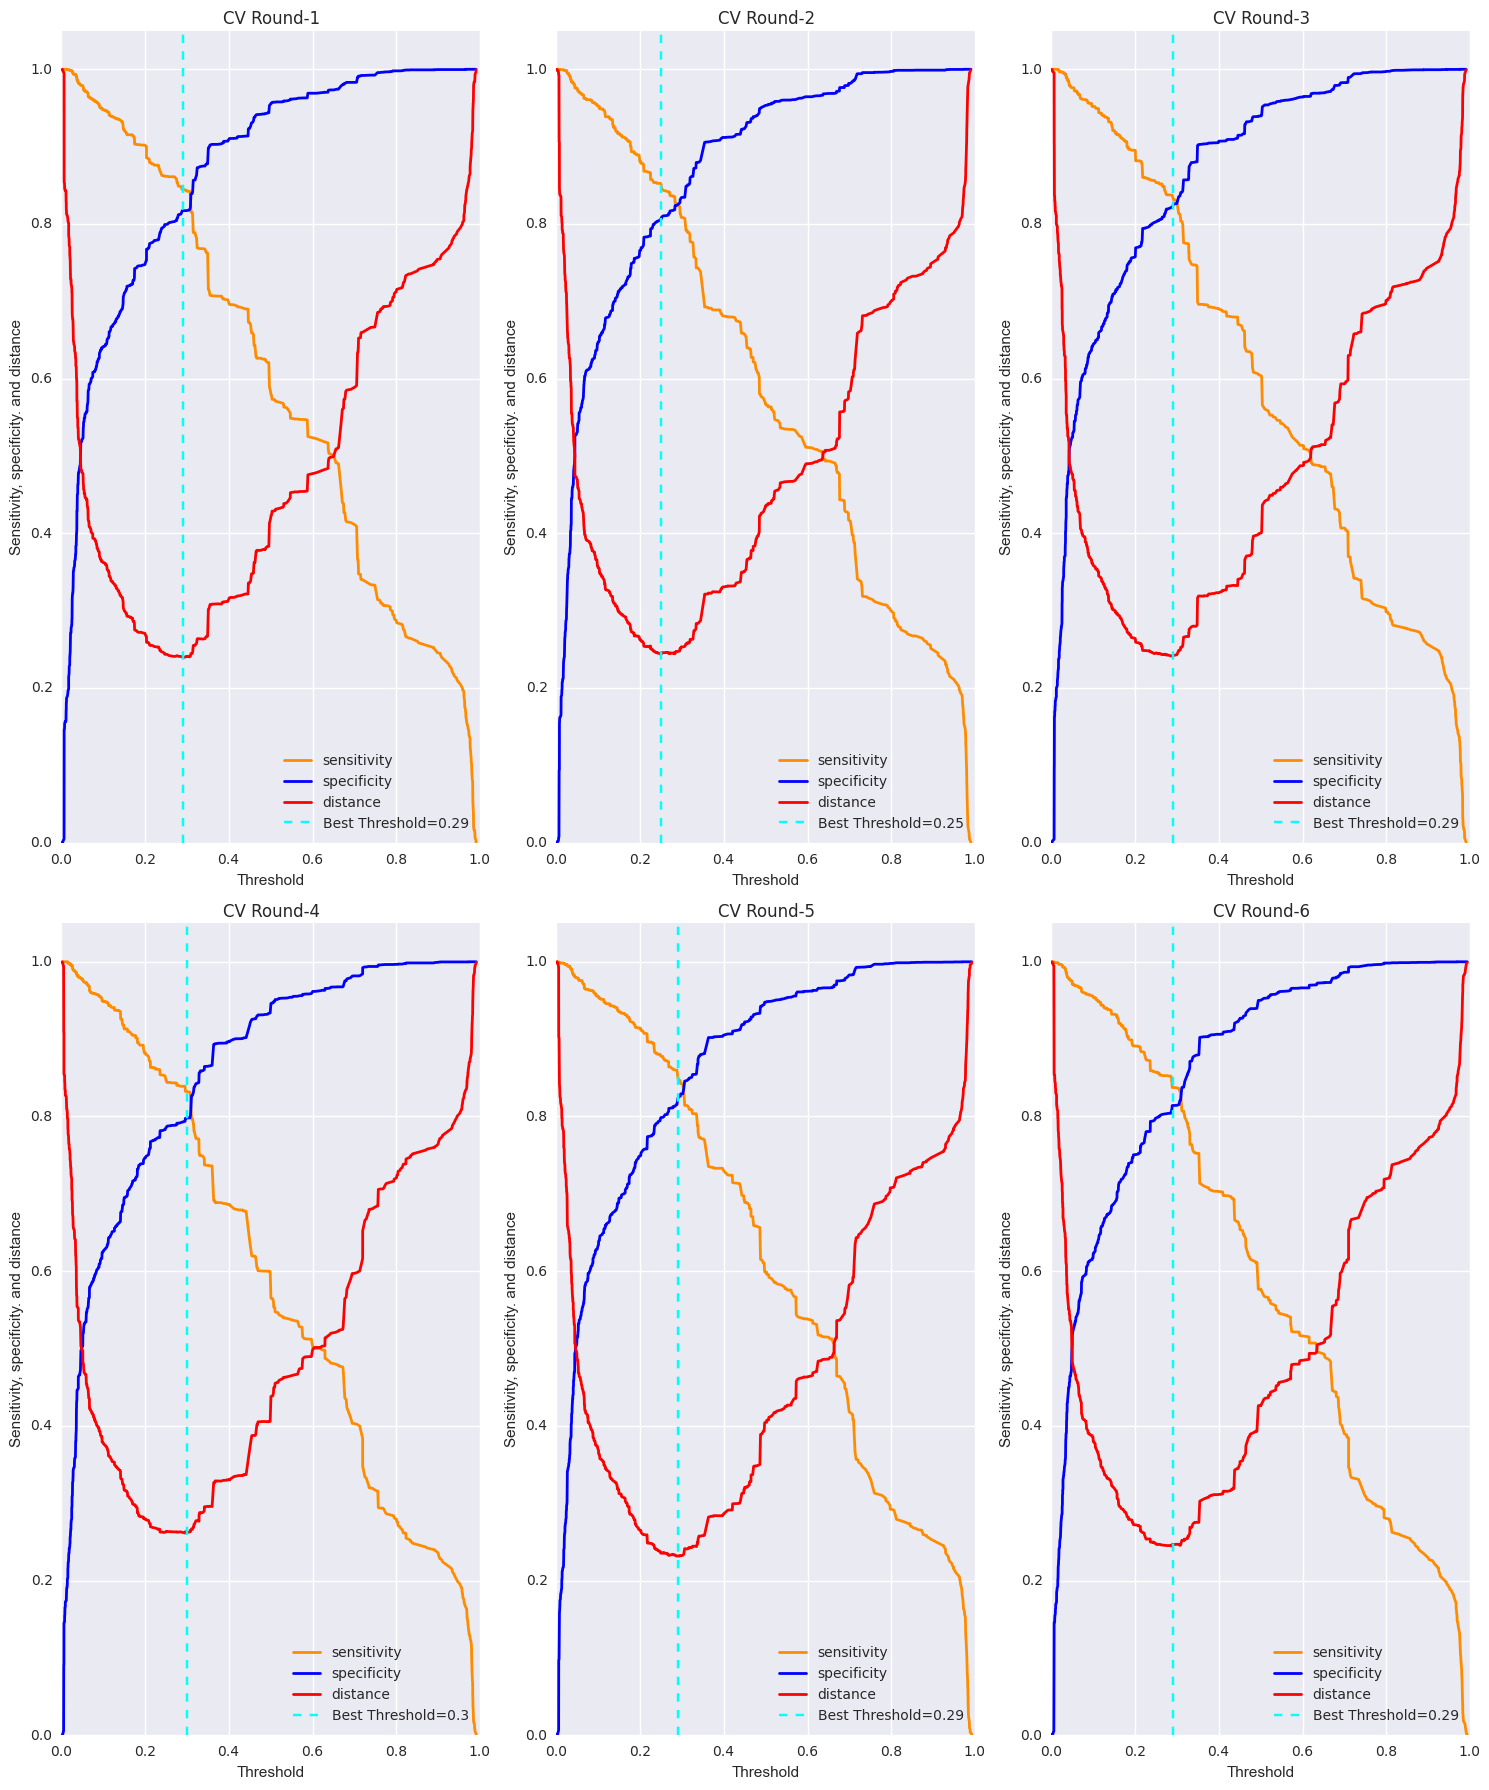

In [62]:
def plot_sens_spec_curves(fpr,tpr,thresholds,ax,title='Sensitivity vs specificity'):
        import matplotlib.pyplot as plt
        from sklearn.metrics import auc
        import math    
        lw=2
        #Find the sensitivity and specificity
        sens = tpr
        spec = 1-fpr

        #Find the distance between (0,1) and the point in fpr, tpr
        dist = [math.sqrt((0-x)**2 + (1-y)**2) for (x, y) in zip(fpr, tpr)]
        line1, = ax.plot(thresholds,sens, color='darkorange',lw=lw, label='sensitivity')
        line2, = ax.plot(thresholds,spec, color='blue',lw=lw, label='specificity')
        line3, = ax.plot(thresholds,dist, color='red',lw=lw, label='distance')
        
        optimal_th = thresholds[dist.index(min(dist))]
        optimal_th = round(optimal_th,2)
        ax.axvline(x=optimal_th,linestyle='--',color="cyan",label='Best Threshold='+str(optimal_th))
        ax.set_title(title)
        ax.set_ylabel('Sensitivity, specificity. and distance')
        ax.set_xlabel('Threshold')
        ax.legend(loc='lower right',fancybox=True, framealpha=0.5)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])

        return ax
    



#plot_sens_spec_curves(fpr[0],tpr[0],thresholds[0])
#plt.tight_layout()






fig, ax = plt.subplots(nrows=2, ncols = 3, figsize=(15,18))
#fig.suptitle('Categorical variables bar plots')
plot_sens_spec_curves(fpr[0],tpr[0],thresholds[0],ax[0,0],title="CV Round-1")
plot_sens_spec_curves(fpr[1],tpr[1],thresholds[1],ax[0,1],title="CV Round-2")
plot_sens_spec_curves(fpr[2],tpr[2],thresholds[2],ax[0,2],title="CV Round-3")

plot_sens_spec_curves(fpr[3],tpr[3],thresholds[3],ax[1,0],title="CV Round-4")
plot_sens_spec_curves(fpr[4],tpr[4],thresholds[4],ax[1,1],title="CV Round-5")
plot_sens_spec_curves(fpr[5],tpr[5],thresholds[5],ax[1,2],title="CV Round-6")


plt.subplots_adjust(top=0.85)
plt.tight_layout()


In 5 out of 6 instances, an optimal threshold of 0.29 is obtained. Hence we will use the average value of 0.28 as the probability threshold. This means, instead of using 0.5 as the probability cutoff to predict the income > 50K, we will use the probability threshold of 0.29. If the calculated probability is greater than 0.29, then we will predict the observation having income as >50K, esle it will be predicted as <=50K 

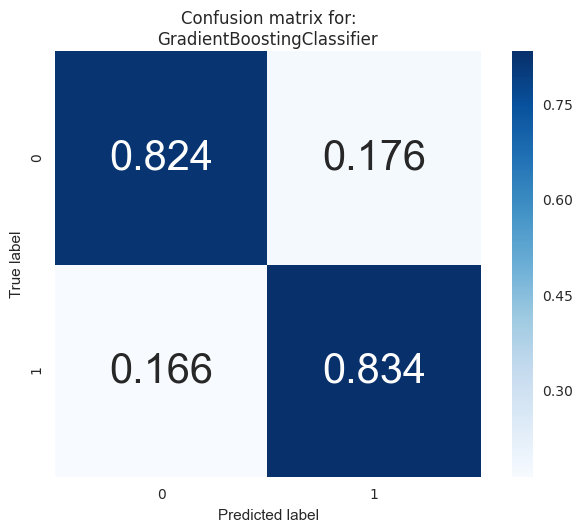

In [67]:
clf1 = (clone(clf1)).fit(X_train_reduced,y_train)
clf_test_scores=np.array(pd.DataFrame(clf1.predict_proba(X_test_reduced))[1])
 
y_pred = np.zeros(len(clf_test_scores))
y_pred[clf_test_scores > 0.29] = 1



from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


# view with a heatmap
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for:\n{}'.format(clf1.__class__.__name__));

#print np.mean(y_test[">50K"] == y_pred)


### Summary

In this data analysis, we performed the following:
1. We used Random forests, Logistic regression and Gradient Boosted Trees (GRT) to predict if a person's income >50K.
2. We determined that the GRT algorithm has the best performance amongst the three algorithms
3. We evaluated 2 different flavors of GRT. The unoptimized model with default parameters and an optimized model, whose parameters are obtained by grid search.
4. The unoptimized and optimized GRT have the same performance, so we considered the unoptimized model, since the unoptimized model is simple and faster to build.
5. We found the 5 best features using the GRT, and refit the models using the reduced training set. For this reduced set also the unoptimized and optimized GRT have the same performance. Hence we finally decided to use the unoptimized GRT model fit on the reduced training data set (with 5 features only).
6. We tweaked the optimal probability threshold using the CV technique, and found that the sensitivity and specificity can be optimal at approximately 0.28 probability cutoff. Using this cutoff, the true positive rate has increased drastically from 57.7% to 83.4% (at the expense of true negative rate decrease from 95% to 82.4%)


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.